In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [2]:
yield_df = pd.read_csv('./Data/Processed/yield_data.csv', header = [0])
date_col = pd.to_datetime(yield_df.pop('Date'))
yield_df.index = date_col

In [3]:
FFR_df = pd.read_csv('./Data/Raw Data/US FFR.csv', header = [0])
FFR_date_col = pd.to_datetime(FFR_df.pop('Date'))
FFR_df.index = FFR_date_col
FFR_df = FFR_df.sort_index()

In [4]:
start_date = yield_df.index[0]
FFR_df = FFR_df[start_date - pd.Timedelta(days = 90):]

In [5]:
pca = PCA(n_components=3)
pca.fit(yield_df)

PCA(n_components=3)

In [6]:
print(pca.explained_variance_ratio_)

[0.93721211 0.05858652 0.00363928]


In [7]:
date_range = []
for i in range(len(FFR_df) - 1):
    date_range.append((FFR_df.index[i], FFR_df.index[i + 1]))

In [8]:
PCA_results = []
PCA_explained_ratio = []
PCA_results_reconstructed = []
PCA_components = []

for i in date_range:
    yield_candidate = yield_df[i[0]: i[1] - pd.Timedelta(days = 1)]
    pca = PCA(n_components=3)
    pca.fit(yield_candidate)
    yield_transformed = pca.transform(yield_candidate)
    PCA_results.append(yield_transformed)
    PCA_explained_ratio.append(PCA_explained_ratio)
    # print(type(pca.inverse_transform(yield_transformed)))
    PCA_results_reconstructed.append(pca.inverse_transform(yield_transformed))
    PCA_components.append(pca.components_)

## Example

In [9]:
def PCA_dataframe_getter(idx):
    example = pd.DataFrame(PCA_results[idx])
    example.columns = ['Level', 'Slope', 'Curvature']
    example.index = yield_df[date_range[idx][0]: (date_range[idx][1] - pd.Timedelta(days = 1))].index

    plt.figure(figsize = (10, 8))
    for i in range(0, 3):
        col_i = example.iloc[:, i]
        name = ['Level', 'Slope', 'Curvature'][i]
        plt.plot(col_i, label = name, alpha = 0.8)
    
    plt.legend()
    plt.grid()
    plt.xlabel('Date')
    plt.ylabel('Principle Factor Value')
    plt.show()

    return example

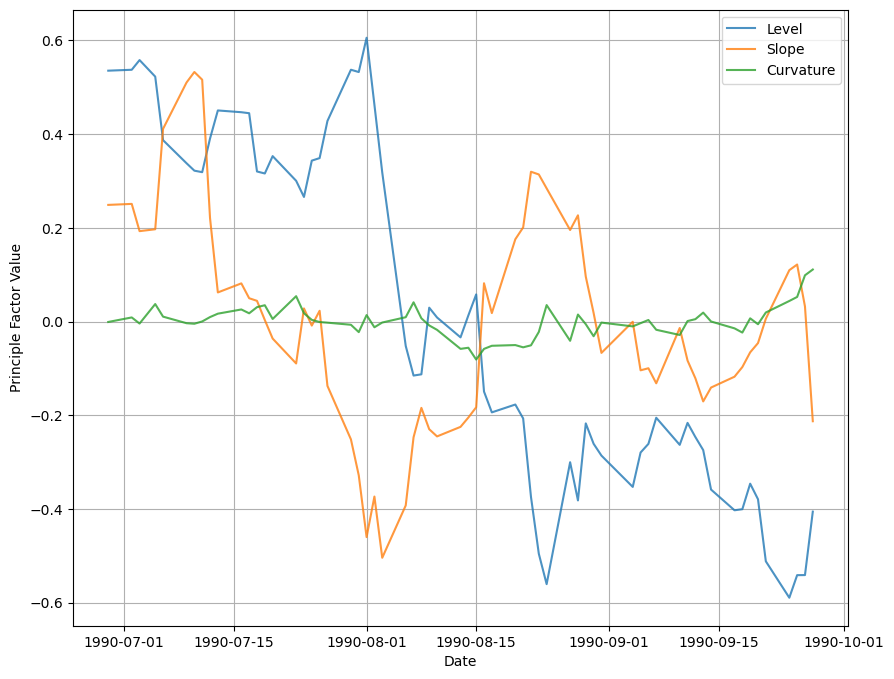

In [10]:
df_0 = PCA_dataframe_getter(2)

In [11]:
def yield_reconstruction(idx, col_name = 'USGG6M'):
    data_1 = PCA_results_reconstructed[idx]
    data_2 = yield_df[date_range[idx][0]: date_range[idx][1] - pd.Timedelta(days = 1)]
    data_1 = pd.DataFrame(data_1, index = data_2.index)
    data_1.columns = ['USGG3M', 'USGG6M', 'USGG2YR', 'USGG5YR', 'USGG10YR', 'USGG30YR']

    data_1 = data_1[[col_name]]
    data_2 = data_2[[col_name]]

    plt.figure(figsize = (12, 8))
    plt.plot(data_2, label = 'Original Yield Curve', alpha = 0.8)
    plt.plot(data_1, label = 'Reconstructed Yield Curve (3 components)', alpha = 0.8)

    plt.xlabel(f"{col_name} Yield Curve")
    plt.ylabel('Yield Value')
    plt.legend()
    plt.grid()
    plt.show()


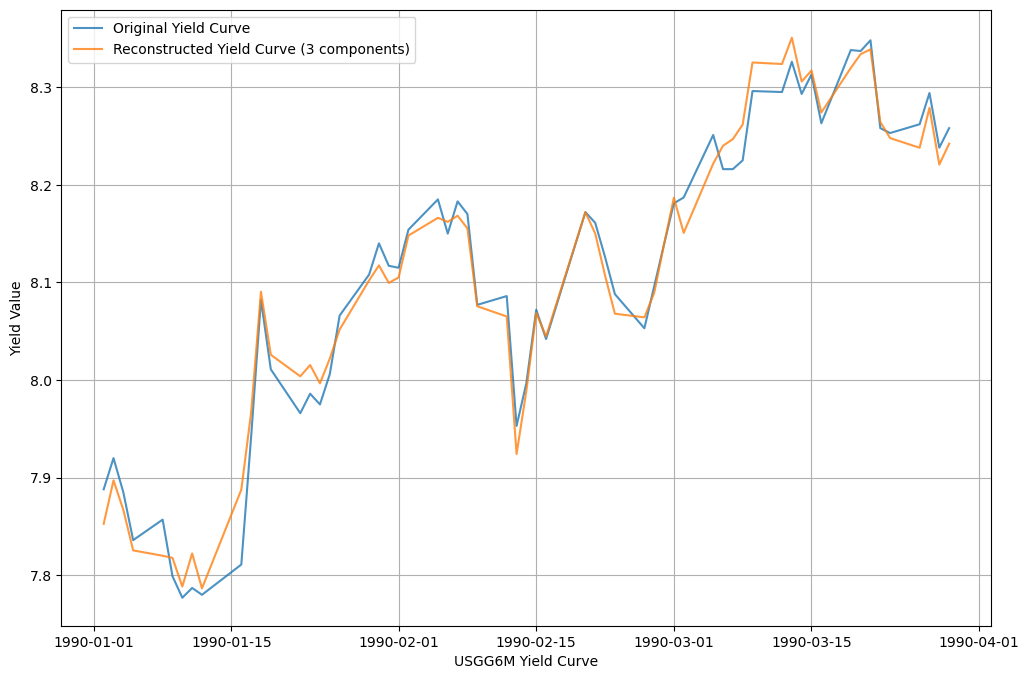

In [12]:
yield_reconstruction(0)

In [13]:
print(PCA_components[0])
for i, component in enumerate(PCA_components[0]):
    print(f"Principal Component {i+1}: {component}")

[[-0.26854986 -0.32018652 -0.52032559 -0.49955786 -0.42177179 -0.35661372]
 [ 0.50221933  0.37374588  0.32681825 -0.10454783 -0.39258325 -0.57985148]
 [ 0.56298799  0.35480657 -0.61473178 -0.24655828  0.16911932  0.29978212]]
Principal Component 1: [-0.26854986 -0.32018652 -0.52032559 -0.49955786 -0.42177179 -0.35661372]
Principal Component 2: [ 0.50221933  0.37374588  0.32681825 -0.10454783 -0.39258325 -0.57985148]
Principal Component 3: [ 0.56298799  0.35480657 -0.61473178 -0.24655828  0.16911932  0.29978212]


In [14]:
def plot_principalcomponents(idx):
    yield_columns = ['USGG3M', 'USGG6M', 'USGG2YR', 'USGG5YR', 'USGG10YR', 'USGG30YR']
    plt.figure(figsize = (10, 8))
    for i, component in enumerate(PCA_components[idx]):
        # print(f"Principal Component {i+1}: {component}")
        plt.plot(yield_columns, component, label = f"Principal Component {i+1}")
    
    plt.ylabel("Principal Components's Values ")
    plt.grid()
    plt.legend()
    plt.show()

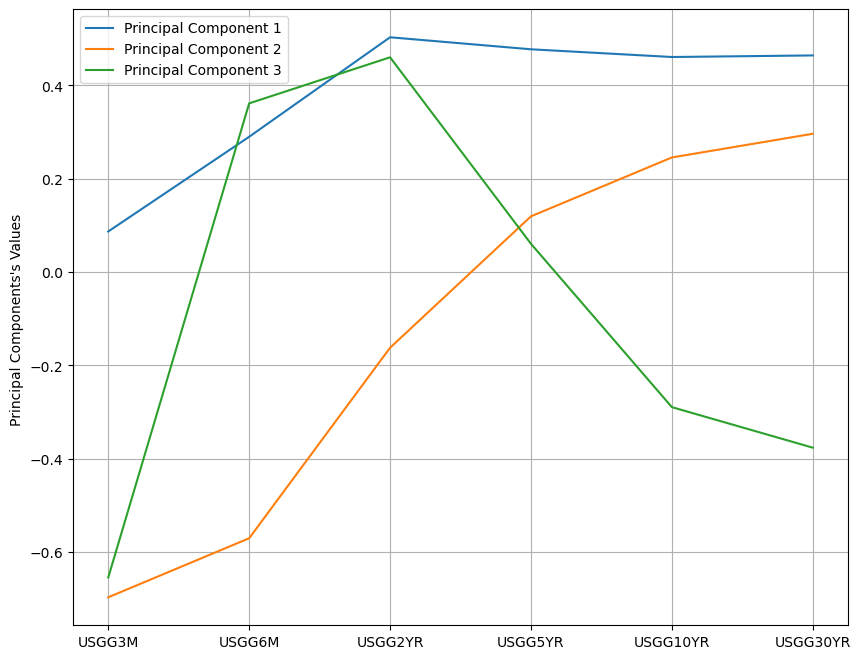

In [15]:
plot_principalcomponents(1)

In [21]:
PCA_components[0][0]

array([-0.26854986, -0.32018652, -0.52032559, -0.49955786, -0.42177179,
       -0.35661372])

In [45]:
def obtain_level(Relevant_components):
    # This method is to obtain the level, which is the leverage of the frist 6 coefficients
    return np.mean(Relevant_components)

def obtain_slope(Relevant_components):
    linear = LinearRegression()
    x = np.asarray([i for i in range(1, 7, 1)]).reshape(6, 1)
    linear.fit(X =x, y = Relevant_components)
    slope = linear.coef_
    return slope

def obtain_curvature(Relevant_components):
    poly_features = PolynomialFeatures(degree=2)
    x = np.asarray([i for i in range(1, 7, 1)]).reshape(6, 1)
    x_poly = poly_features.fit_transform(x)
    # print(x_poly)
    regression_model = LinearRegression()
    regression_model.fit(x_poly, Relevant_components)
    curvature = regression_model.coef_[2]
    # print(curvature)
    return curvature

In [54]:
len(PCA_components)

PCA_index = [date_range[i][0] for i in range(len(date_range))]
yield_factors = pd.DataFrame(0, index = PCA_index, columns = ['Level', 'Slope', 'Curvature'])

In [55]:
for i in range(len(PCA_index)):
    yield_factors.iloc[i, 0] = obtain_level(PCA_components[i][0])
    yield_factors.iloc[i, 1] = obtain_slope(PCA_components[i][1])
    yield_factors.iloc[i, 2] = obtain_curvature(PCA_components[i][2])

In [56]:
yield_factors.to_csv('./Data/Processed/yield_PCA_monthly.csv')